In [3]:
import kaldiio
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# Paths to your SCP and CSV files
train_scp_path = '../Files/layer_train_features/layer_1_features_train.scp'
train_labels_csv_path = '../Files/y_train_age_group.csv'
test_scp_path = '../Files/layer_test_features/layer_1_features_test.scp'
test_labels_csv_path = '../Files/y_test_age_group.csv'

# Function to load features from an SCP file and corresponding labels from a CSV
def load_data(scp_path, labels_csv_path, is_training=True):
    # Load features from SCP file
    features_dict = {}
    with kaldiio.ReadHelper(f'scp:{scp_path}') as reader:
        for key, numpy_array in tqdm(reader, desc='Loading features from SCP'):
            features_dict[key] = numpy_array

    print(f"Loaded {len(features_dict)} feature entries fromlayer_22_features_train the SCP file.")

    # Load labels from CSV file
    labels_df = pd.read_csv(labels_csv_path)

    # Process labels based on whether it's training or testing data
    if is_training:
        # Remove 'train_pfstar/' for training data
        names = labels_df['Name'].str.replace('train_pfstar/', '').str.replace('.wav', '').values
    else:
        # Remove 'test_pfstar/' for testing data
        names = labels_df['Name'].str.replace('test_pfstar/', '').str.replace('.wav', '').values

    ages = labels_df['Age_Group'].values

    X = []
    y = []

    # Using tqdm to monitor progress
    for name, age in tqdm(zip(names, ages), total=len(names), desc='Processing labels'):
        if name in features_dict:
            # Extract mean features as global features
            mean_features = np.mean(features_dict[name], axis=0)
            X.append(mean_features)
            y.append(age)
        else:
            print(f"Warning: {name} not found in SCP file.")

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print(f"Final data contains {X.shape[0]} samples with {X.shape[1]} features each.")

    return X, y

# Load training data
X_train, y_train = load_data(train_scp_path, train_labels_csv_path, is_training=True)

# Check if training data is loaded correctly
if X_train.size == 0 or y_train.size == 0:
    raise ValueError("Training data was not loaded correctly. Please check the SCP and label files.")

# Load testing data
X_test, y_test = load_data(test_scp_path, test_labels_csv_path, is_training=False)

# Check if testing data is loaded correctly
if X_test.size == 0 or y_test.size == 0:
    raise ValueError("Testing data was not loaded correctly. Please check the SCP and label files.")

# Create an SVM pipeline with scaling
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear'))

# Train the SVM model
svm_model.fit(X_train, y_train)

# Test the SVM model
y_pred = svm_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))


Loading features from SCP: 856it [00:10, 83.69it/s] 


Loaded 856 feature entries fromlayer_22_features_train the SCP file.


Processing labels: 100%|██████████| 856/856 [00:00<00:00, 2249.93it/s]


Final data contains 856 samples with 1024 features each.


Loading features from SCP: 129it [00:00, 147.87it/s]


Loaded 129 feature entries fromlayer_22_features_train the SCP file.


Processing labels: 100%|██████████| 129/129 [00:00<00:00, 2762.12it/s]


Final data contains 129 samples with 1024 features each.
              precision    recall  f1-score   support

       10-13       0.96      0.87      0.92        62
         4-6       0.81      0.93      0.87        14
         7-9       0.86      0.92      0.89        53

    accuracy                           0.90       129
   macro avg       0.88      0.91      0.89       129
weighted avg       0.90      0.90      0.90       129



ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (4).

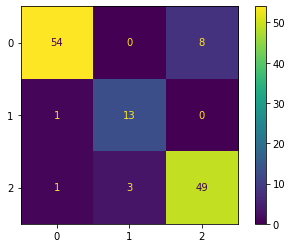

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=svm_model.classes_)
disp.plot()
plt.show()